# ML para predecir el gesto

Creación y evaluación de modelos de Machine Learning para predecir qué gesto está realizando el paciente

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,AnkleAngleRight_standardDeviation,AnkleAngleRight_Maximum,AnkleAngleRight_Minimum,AnkleAngleRight_Mean,...,ShoulderAngleRight_Kurtosis,KneeAngleLeft_standardDeviation,KneeAngleLeft_Maximum,KneeAngleLeft_Minimum,KneeAngleLeft_Mean,KneeAngleLeft_Range,KneeAngleLeft_Variance,KneeAngleLeft_CoV,KneeAngleLeft_Skewness,KneeAngleLeft_Kurtosis
0,101,0,1,1,stand,59,1.3386855330026355,61.44967116407663,56.37479894374112,59.04653908199285,...,0.24725567691914474,0.20870629032593843,3.832570179813752,2.8054311678768347,3.2264190605352057,1.0271390119369173,0.043558315621614906,0.06468666543623684,1.2879069756445671,1.7710014047083118
1,101,0,2,1,stand,44,0.7072848658090999,60.37675046729619,57.50310404536253,59.143816844691166,...,-1.7517830977424425,0.22148909073910306,4.246380837895045,3.453588833486254,3.719954248373769,0.792792004408791,0.04905741731643463,0.059540810437636475,0.8191624841671131,-0.3639623655630544
2,101,0,3,1,stand,53,0.7902137110458896,61.020041606361104,57.64835001885528,59.03961850510746,...,0.7198891878500557,0.20016295285928792,4.1039460408883,3.3254621985904564,3.6007082025080748,0.778483842297844,0.040065207697349524,0.05558988443436331,0.898628596731062,0.19518406030957225
3,101,0,4,1,stand,57,1.132751307917828,60.769706378814135,55.85153188379184,58.434266875398926,...,0.4958653590427531,0.3449046585971368,4.543961728545065,3.3010043179588577,3.7735818874638336,1.242957410586207,0.1189592235220075,0.09139980763182588,0.6059487765546326,-0.6882051769936814
4,101,0,5,1,stand,60,1.003883998475067,60.46871115477053,56.25276707261665,58.87072225510939,...,0.39390720825161907,0.2176579492233252,4.160299131388289,3.14308681224766,3.492943555569523,1.0172123191406288,0.04737498286010361,0.06231361765816916,1.445851599208949,1.9573808887146877


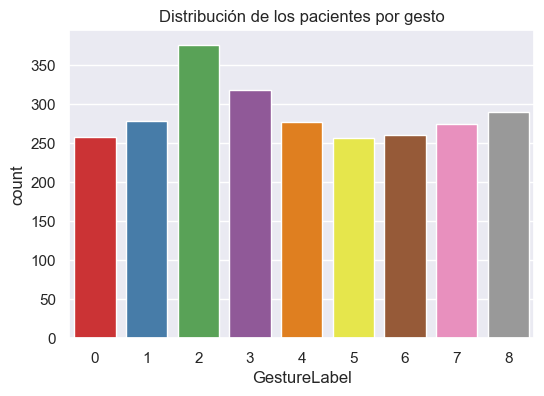

In [3]:
#---------Distribución de las clases--------
plt.figure(figsize=(6,4))

sns.countplot(x="GestureLabel", data=df, palette = "Set1")
plt.title("Distribución de los pacientes por gesto")
plt.show()

## 1. Preprocesado

### 1.1 Codificar variables

In [4]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [5]:
# Dividimos en train y test
df_train, df_test = train_test_split(df, test_size = 0.3, stratify=df['GestureLabel'])

# Dividimos el conjunto de train en varibales independientes y en target
train_X = df_train.drop(['GestureLabel'], axis = 1)
train_y = pd.DataFrame(df_train['GestureLabel'])

# Dividimos el conjunto de test
test_X = df_test.drop(['GestureLabel'], axis = 1)
test_y = pd.DataFrame(df_test['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()


## 2. Modelos de ML
Se ha creado una función para entrenar y evaluar los modelos

In [6]:
#-------Funcion para entrenar los modelos-----------
def aplicar_modelos(modelos: list, X:pd.DataFrame, y:pd.DataFrame, tX:pd.DataFrame, ty:pd.DataFrame):
   """
   Aplica una lista de modelos de aprendizaje automático a los datos de prueba y muestra
   los informes de evaluación.

   Parámetros:
   modelos (list): Lista de modelos de aprendizaje automático a evaluar.
   * X: datos de entrenamiento.
   * y: target de entrenamiento.
   * tX: datos de prueba.
   * ty: target de prueba.
   """
   # Iteramos sobre los modelos
   for modelo in modelos:
      modelo.fit(X,y) # entrenamos el modelo
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 

In [7]:
# creación de los modelos
knn = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

models = [knn, dtree, nb, svm, rf, lr]

# entrenamiento + evaluación
aplicar_modelos(models, train_X, train_y, test_X, test_y)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        77
           1       0.92      0.94      0.93        84
           2       0.79      0.86      0.82       113
           3       0.77      0.80      0.79        96
           4       0.82      0.76      0.79        83
           5       0.75      0.70      0.72        77
           6       0.96      0.94      0.95        78
           7       0.94      0.90      0.92        82
           8       0.91      0.91      0.91        87

    accuracy                           0.85       777
   macro avg       0.86      0.85      0.86       777
weighted avg       0.86      0.85      0.85       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.87      0.88      0.88        77
           1       0.91      0.86      0.88        84
           2       0.90      0.91      0.90       113
           3    

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* Confusion matrix: cuanto más valores en la diagonal mejor
* Precision: cuanto más alta mejor
* Recall: cuanto más alta mejor
* F1-measure o F-score: cuanto más alta mejor
* Accuracy: cuanto más alta mejor

En la mayoría de ejecutiones los mejores son **DecisionTreeClassifier**, **KNeighborsClassifier** o **Regresión logistica**

In [8]:
#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX, ty):
    """
    Grafica la matriz de confusión para un modelo dado.

    Parámetros:
    * modelo: El modelo de clasificación entrenado.
    * tX: Los datos de prueba.
    * ty: Los valores reales del target para los datos de prueba.
    """
    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title('Confusion Matrix ' + modelo.__class__.__name__)
    plt.show()


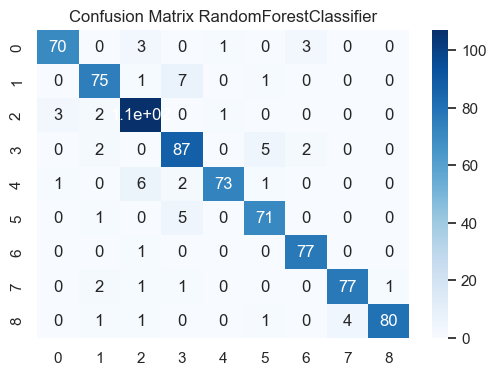

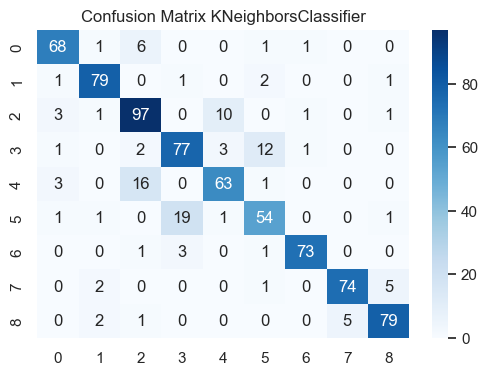

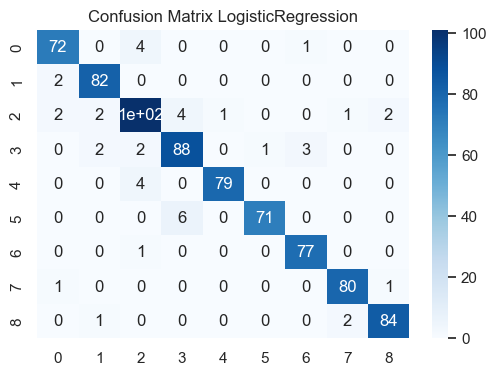

In [9]:
# Confusion Matrix para mejores modelos
plot_confusion_matrix(rf, test_X, test_y)
plot_confusion_matrix(knn, test_X, test_y)
plot_confusion_matrix(lr, test_X, test_y)

## 3. Hipermetrización

In [10]:
#-------------Parametros---------------
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [5, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [11]:
# GridSearchCV instances
gs_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
gs_dtree = GridSearchCV(dtree, param_grid_dtree, cv=5, scoring='accuracy')
gs_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='accuracy')
gs_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
gs_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
gs_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy') # !!!!!
# El parámetro cv=5 en GridSearchCV especifica una validación cruzada
# de 5 particiones (5-fold cross-validation)


In [12]:
def aplicar_hiperparametrizacion(modelos: list, X, y):
    for modelo in modelos:
        modelo.fit(X, y)
        print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
        # print(modelo.cv_results_) 
        print("Best parameters: ", modelo.best_params_)
        print("Best score: ", modelo.best_score_)

In [13]:
modelos_gs = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]

aplicar_hiperparametrizacion(modelos_gs, train_X, train_y)


Modelo: KNeighborsClassifier
Best parameters:  {'n_neighbors': 1}
Best score:  0.8173401518956517

Modelo: DecisionTreeClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 10}
Best score:  0.9144544389145093

Modelo: GaussianNB
Best parameters:  {'var_smoothing': 6.579332246575683e-06}
Best score:  0.7676757530097561

Modelo: SVC
Best parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.9370774546063346

Modelo: RandomForestClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100}
Best score:  0.9575057455519536


In [14]:
def test_hiperparametrizacion(modelos, tX, ty):
       for modelo in modelos:
            best_modelo = modelo.best_estimator_ 
            prediction = best_modelo.predict(tX) #  predicciones en los datos de prueba
            report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
            print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
            print(report) 

test_hiperparametrizacion(modelos_gs, test_X, test_y)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        77
           1       0.92      0.94      0.93        84
           2       0.79      0.86      0.82       113
           3       0.77      0.80      0.79        96
           4       0.82      0.76      0.79        83
           5       0.75      0.70      0.72        77
           6       0.96      0.94      0.95        78
           7       0.94      0.90      0.92        82
           8       0.91      0.91      0.91        87

    accuracy                           0.85       777
   macro avg       0.86      0.85      0.86       777
weighted avg       0.86      0.85      0.85       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        77
           1       0.88      0.93      0.90        84
           2       0.91      0.93      0.92       113
           3    

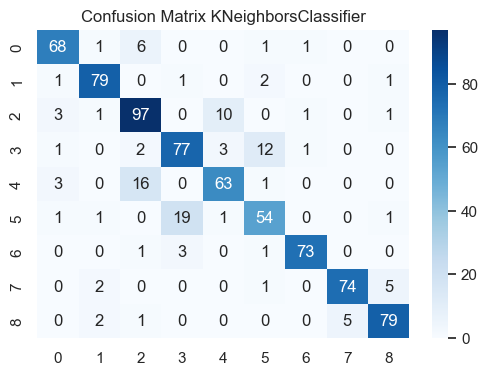

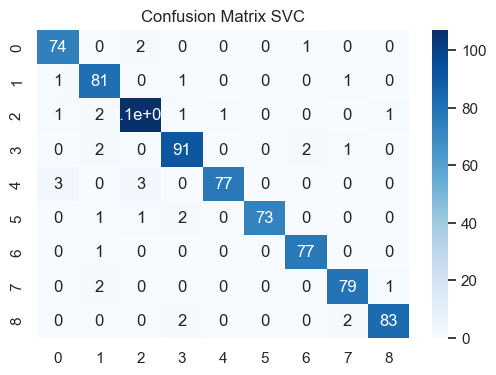

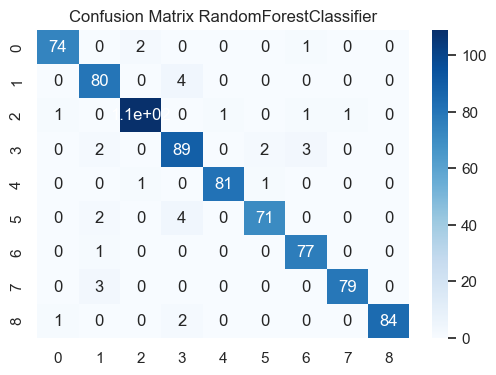

In [15]:
# Confusion Matrix para mejores modelos
plot_confusion_matrix(gs_knn.best_estimator_ , test_X, test_y)
plot_confusion_matrix(gs_svm.best_estimator_ , test_X, test_y)
plot_confusion_matrix(gs_rf.best_estimator_ , test_X, test_y)


In [16]:
df_X = df.drop(['GestureLabel'], axis = 1)
df_copy = df.copy()
df_copy['Prediction'] = gs_svm.predict(df_X)

# Insertar las nuevas columnas en las posiciones deseadas
df_copy.insert(2, 'Prediction', df_copy.pop('Prediction')) 

# Ordenar el DataFrame
df_copy['RepetitionNumber'] = df_copy['RepetitionNumber'].astype(int)
df_sorted = df_copy.sort_values(by=['SubjectID', 'GestureLabel', 'RepetitionNumber'])

# Ajustar la configuración de pandas para mostrar todas las filas
#pd.set_option('display.max_rows', None)

# Mostrar todas las filas del DataFrame
df_sorted 

,SubjectID,GestureLabel,Prediction,RepetitionNumber,CorrectLabel,Position,Duration,AnkleAngleRight_standardDeviation,AnkleAngleRight_Maximum,AnkleAngleRight_Minimum,...,ShoulderAngleRight_Kurtosis,KneeAngleLeft_standardDeviation,KneeAngleLeft_Maximum,KneeAngleLeft_Minimum,KneeAngleLeft_Mean,KneeAngleLeft_Range,KneeAngleLeft_Variance,KneeAngleLeft_CoV,KneeAngleLeft_Skewness,KneeAngleLeft_Kurtosis
0,101,0,0,1,1,2.0,59,1.338686,61.449671,56.374799,...,0.247256,0.208706,3.832570,2.805431,3.226419,1.027139,0.043558,0.064687,1.287907,1.771001
1,101,0,0,2,1,2.0,44,0.707285,60.376750,57.503104,...,-1.751783,0.221489,4.246381,3.453589,3.719954,0.792792,0.049057,0.059541,0.819162,-0.363962
2,101,0,0,3,1,2.0,53,0.790214,61.020042,57.648350,...,0.719889,0.200163,4.103946,3.325462,3.600708,0.778484,0.040065,0.055590,0.898629,0.195184
3,101,0,0,4,1,2.0,57,1.132751,60.769706,55.851532,...,0.495865,0.344905,4.543962,3.301004,3.773582,1.242957,0.118959,0.091400,0.605949,-0.688205
4,101,0,0,5,1,2.0,60,1.003884,60.468711,56.252767,...,0.393907,0.217658,4.160299,3.143087,3.492944,1.017212,0.047375,0.062314,1.445852,1.957381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,307,8,8,8,1,2.0,48,15.325924,79.580870,40.123700,...,0.465005,6.503301,34.562731,12.927247,20.093870,21.635485,42.292929,0.323646,0.864714,-0.347162
2585,307,8,8,9,1,2.0,48,17.736973,79.784653,41.581318,...,-0.019000,6.647659,31.694842,10.259170,18.843740,21.435673,44.191368,0.352778,0.586756,-0.874793
2586,307,8,8,10,1,2.0,47,18.029198,79.936831,41.439240,...,-1.203659,5.285898,31.108523,13.547613,19.986877,17.560910,27.940723,0.264468,0.356334,-1.055977
2587,307,8,8,11,1,2.0,51,15.416612,79.596429,41.354173,...,-0.087088,6.237513,31.632591,10.289983,18.230755,21.342608,38.906569,0.342142,0.489201,-1.100134


## 4. Feature Selection

### 4.1 SelectKBest

In [17]:
# Definimos feature Selection K=40 (selecciona entonces las 40 variables que considere mas importantes)
feature_selection=SelectKBest(k=40)

# Fit Feature Selection (entrena y hace una tranfosmada)
feature_selection.fit_transform(train_X, train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)
print(train_X.columns[selected])

Index(['ArmsTogetherAngle_standardDeviation', 'ArmsTogetherAngle_Minimum',
       'ArmsTogetherAngle_Mean', 'ArmsTogetherAngle_Range',
       'ArmsTogetherAngle_Variance', 'ArmsTogetherAngle_CoV',
       'HipAngleRight_standardDeviation', 'HipAngleRight_CoV',
       'RightArmAngle_standardDeviation', 'RightArmAngle_Minimum',
       'RightArmAngle_Mean', 'RightArmAngle_Range', 'RightArmAngle_Variance',
       'RightArmAngle_CoV', 'ElbowAngleRight_standardDeviation',
       'ElbowAngleRight_Maximum', 'ElbowAngleRight_Range',
       'ElbowAngleRight_Variance', 'ElbowAngleRight_CoV',
       'HipAngleLeft_standardDeviation', 'HipAngleLeft_CoV',
       'ShoulderAngleLeft_standardDeviation', 'ShoulderAngleLeft_Maximum',
       'ShoulderAngleLeft_Minimum', 'ShoulderAngleLeft_Mean',
       'ShoulderAngleLeft_Range', 'ShoulderAngleLeft_Variance',
       'ShoulderAngleLeft_CoV', 'LeftArmAngle_standardDeviation',
       'LeftArmAngle_Minimum', 'LeftArmAngle_Mean', 'LeftArmAngle_Range',
       'Lef

### 4.2 Entrenar con las variables sleccionadas

In [18]:
# creación de los modelos
knn_fs = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_fs = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs, lr_fs]


In [19]:
# Reduce train_X to the selected features with .transform(X)
#creamos un data frame vacio para hacer una tabla donde esten 
# las variables con la trsnformada de la X.
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(feature_selection.transform(train_X),
                 columns=train_X.columns[selected])
# train -> train and validation
X_fs_train, X_validation, y_fs_train, y_validation = train_test_split(X_fs, train_y, train_size=0.7,random_state=42)


aplicar_modelos(models_fs, X_fs_train, y_fs_train, X_validation, y_validation)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        55
           1       0.86      0.91      0.88        53
           2       0.84      0.83      0.83        86
           3       0.65      0.68      0.67        69
           4       0.77      0.77      0.77        62
           5       0.69      0.57      0.62        58
           6       0.93      0.97      0.95        58
           7       0.88      0.90      0.89        42
           8       0.93      0.93      0.93        61

    accuracy                           0.82       544
   macro avg       0.83      0.83      0.83       544
weighted avg       0.82      0.82      0.82       544


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        55
           1       0.84      0.91      0.87        53
           2       0.94      0.90      0.92        86
           3    

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4.3 Recursive feature elimination

In [20]:
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_rfe = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

In [21]:
models_with_coef = [dtree_rfe, rf_rfe, lr_rfe]

In [22]:
def seleccion_variables(models, X, y):
    for model in models:
        rfecv = RFECV(
            estimator=model,
            scoring="accuracy",
            n_jobs=2 # Number of cores to run in parallel while fitting across folds. 
        )
        rfecv.fit(X, y)
        print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
        print(f"Optimal number of features: {rfecv.n_features_}")
        selected = rfecv.get_feature_names_out()
        print(selected)
        
        X_rfe= train_X[selected]
        # train -> train and validation
        X_rfe_train, X_validation, y_rfe_train, y_validation = train_test_split(X_rfe, y, train_size=0.7,random_state=42)
        aplicar_modelos([model], X_rfe_train, y_rfe_train, X_validation, y_validation)

seleccion_variables(models_with_coef, train_X, train_y)


Modelo: DecisionTreeClassifier
Optimal number of features: 15
['ArmsTogetherAngle_standardDeviation' 'HipAngleRight_Maximum'
 'RightArmAngle_Mean' 'RightArmAngle_CoV' 'ElbowAngleRight_Maximum'
 'WristAngleRight_Mean' 'HipAngleLeft_Maximum' 'HipAngleLeft_Range'
 'ShoulderAngleLeft_Maximum' 'ShoulderAngleLeft_Mean'
 'LeftArmAngle_Maximum' 'LeftArmAngle_Mean' 'ShoulderAngleRight_Maximum'
 'ShoulderAngleRight_Variance' 'KneeAngleLeft_Range']

Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        55
           1       0.89      0.92      0.91        53
           2       0.87      0.84      0.85        86
           3       0.91      0.88      0.90        69
           4       0.95      1.00      0.98        62
           5       0.93      0.91      0.92        58
           6       0.93      0.91      0.92        58
           7       0.83      0.90      0.86        42
           8       0.98      0.92     

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Modelo: LogisticRegression
Optimal number of features: 77
['RepetitionNumber' 'AnkleAngleRight_standardDeviation'
 'AnkleAngleRight_Minimum' 'AnkleAngleRight_Mean' 'AnkleAngleRight_Range'
 'AnkleAngleRight_Kurtosis' 'KneeAngleRight_Maximum'
 'KneeAngleRight_Minimum' 'KneeAngleRight_Mean' 'KneeAngleRight_Range'
 'KneeAngleRight_Variance' 'KneeAngleRight_Kurtosis'
 'ArmsTogetherAngle_standardDeviation' 'ArmsTogetherAngle_Maximum'
 'ArmsTogetherAngle_Minimum' 'ArmsTogetherAngle_Mean'
 'ArmsTogetherAngle_Range' 'ArmsTogetherAngle_Kurtosis'
 'HipAngleRight_Maximum' 'HipAngleRight_Minimum' 'HipAngleRight_Mean'
 'HipAngleRight_Range' 'HipAngleRight_Variance'
 'RightArmAngle_standardDeviation' 'RightArmAngle_Maximum'
 'RightArmAngle_Minimum' 'RightArmAngle_Mean' 'RightArmAngle_Range'
 'ElbowAngleRight_standardDeviation' 'ElbowAngleRight_Maximum'
 'ElbowAngleRight_Minimum' 'ElbowAngleRight_Mean' 'ElbowAngleRight_Range'
 'ElbowAngleRight_Kurtosis' 'WristAngleRight_standardDeviation'
 'WristAngl

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
